# Predicting responstimes with a ReLU neural network - improving optimization

In this notebook I want to enhance the optimization procedure. I focus on the case of the crossed diamond, which is the so far most difficult learning task.

I want to have evidence that the excursions of the cost function happen because of occasionally extreme gradients and apply gradient clipping.

I also want to apply a greedy unit-wise supervised (pre-)training. I want to implement this by manipulating the regularization parameters.

The ultimate goal of the notebook is to improve the minima of the crossed diamond.
## Summary of findings
### Gradient clipping makes no sense
The scatter plots of the $\infinite$-norm of the gradient against the MSE in the subsequent iteration showed no correlation between these two quantities. This indicates that the extreme gradients cause no excursions in the MSE. 

On the contraty, some correlation between the $\infinite$-norm of the gradient and the MSE in the same iteration could be identified on the scatter plots of these two, suggesting that some "naturally existing" but relatively rare extreme values in the MSE cause the variation in the gradient.

The hipothesis about the parameter vector being catapulted away from the convergence point was also disproved by an examination on the distribution of the training MSE in the late phases of the training (when it reached a stationer state after its initial descent). It turned out that its distribution is identical to that of the test MSE, giving evidence that the MSE excursions are present without any change to the parameter vector, so they cannot be caused by a sudden big change in the vector.
### Greedy unit-wise supervised pre-training is awsome!
**With the help of greedy unit-wise supervised pre-training, the MSE of the diamond concurrency structure could be reduced by 5 to 6 orders of magnitude!** This result was obtained in cc. 15500 iterations without oversizing the network. The best MSE was obtained when the number of active ReLUs (i.e. the units with trained weight parameters) was at an optimal value, i.e. the network was succint: its representational capacity matched the complexity of the problem. Activating further units increased the MSE.

The greedy unit-wise supervised training method is similar to the [cascade correlation training method](http://web.cs.iastate.edu/~honavar/fahlman.pdf) in that it does not require the units to be organized in a layered architecture. The inputs of the network are connected to each processing unit of the net. The units are numbered sequentially, and each unit feeds into each higher numbered unit. The output of the highest numbered unit is the output of the network.

I follow a phased approach to train the net, one stage for each ReLU, starting with the highest numbered unit. The weights of the connections to and from all the other ReLUs are so heavily regularized that they are practically "frozen". The stage completes when the MSE shows no improvement for a predifined number of iterations. To start the next stage, the regularzation of the next highest numbered unit is relaxed so that the unit can start learning. One can slightly increase the regularization of the already trained units to encourage the flow of the gradient into the new unit, but this option was very little used during the experiments. Strong L1 regularization encouraging sparsity proved to be essential.

Contrary to the bottom-up approach of cascade correlation, where once a unit is added to the network the function it computes is not allowed to change, only how it feeds into later-added units, this method is top-down. The idea is that once a ReLU is trained to do its best to match the desired output using a linear combination of the network inputs, we offer it with a more complex, non-linear function of the network-inputs that it can tune to its needs.

### Line search is also awsome!
Setting the step size dynamically via line search also worked very well, reducing the MSE by 7 orders of magnitude in cc. 25% more computation time (compared to GUST).

In [1]:
from collections import defaultdict
from itertools import count
from pprint import pprint
import theano
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from theano import pp
from theano import tensor as T
from theano import function
from theano.ifelse import ifelse
import numpy as np
from theano.compile.nanguardmode import NanGuardMode
np.set_printoptions(precision=3, suppress=True)

/home/dini/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
%matplotlib inline

## Synthetizing data 
(THis is copy-paste from a previous notebook.)

In [3]:
class Barrier(object):
    def __init__(self, name):
        self.name = name
        self.in_edges = list()
        self.out_edges = list()

    def __str__(self):
        return "Barrier('{}')".format(self.name)
    __repr__ = __str__
    
    class BarrierDict(defaultdict):
        def __missing__(self, key):
            barrier = self[key] = Barrier(key)
            return barrier
                
class TrxBp(object):
    """ A transaction blue-print
    """
    def __init__(self, name, fr, to, loc=0., scale=1., alpha=-1.0, beta=.10):
        fr.out_edges.append(self)
        to.in_edges.append(self)
        self.fr, self.to = fr, to
        self.name, self.loc, self.scale, self.alpha, self.beta = \
             name,      loc,      scale,      alpha,      beta
        
    def __str__(self):
        if self.loc != 0 or self.scale != 1.:
            return "TrxBp('{}', {:3.1f}, {:3.1f})".format(self.name, self.loc, self.scale)
        else:
            return "TrxBp('{}')".format(self.name)
        
    __repr__ = __str__
        
    def collect_events(self, events, X, refTime=0):
        start  = refTime + np.exp(np.random.normal(self.loc + self.alpha, self.scale * self.beta))
        finish = start   + np.exp(np.random.normal(self.loc             , self.scale            ))
        events.extend([(start, "{" + self.name), (finish, self.name + "}")])
        X.append(finish - start)
        return finish
    
class FSBGraph(object):
    
    def __init__(self):
        self.nodes = Barrier.BarrierDict()
        self.edges = list()
        self.node_count = count(0)
        
    def next_node_id(self):
        return "B{}".format(next(self.node_count))
        
    def add_edge(self, from_id, to_id, loc=0., scale=1., alpha=-1.0, beta=.10):
        name = "{}-->{}".format(from_id, to_id)
        self.edges.append(TrxBp(name, self.nodes[from_id], self.nodes[to_id], 
                                loc, scale, alpha, beta)
                         )
        
    def walk_in_topological_order(self, start_node_id, edge_func, node_func):
        """ Visit each edge and non-start node in a deterministic topological order
        """
        pending_edges = { node: set(node.in_edges) for node in self.nodes.values() }
        pending_nodes = [self.nodes[start_node_id]]
        while pending_nodes:
            from_node = pending_nodes.pop(-1)
            for edge in from_node.out_edges:
                to_node = edge.to
                pending_edges[to_node].discard(edge)
                edge_func(edge)
                if not pending_edges[to_node]:
                    pending_nodes.append(to_node)
                    node_func(to_node)
        if any(pending_edges.values()):
            raise ValueError('Cyclic graph!')

    def collect_events(self, start_node_id, end_node_id, events, X, refTime=0):
        finish_times = dict()
        finish_times[self.nodes[start_node_id]] = refTime
        
        def edge_func(trx):
            #print trx
            finish_times[trx] = trx.collect_events(events, X, finish_times[trx.fr])
    
        def node_func(barrier):
            #print barrier
            finish_times[barrier] = max(finish_times[trx] for trx in barrier.in_edges)
            
        self.walk_in_topological_order(start_node_id, edge_func, node_func)
        return finish_times[self.nodes[end_node_id]] - refTime

In [4]:
g = FSBGraph()
g.add_edge('start', 'end', alpha=-100, beta=0.0)
g.add_edge('start', 'end', alpha=-100, beta=0.0)
X = list()
events = list()
RT = g.collect_events('start', 'end', events, X, refTime=0)
print max(X) - RT

0.0


##### Demonstrate sampling on a crossed diamond structure

Below a 5-edge diamond-like graph is defined:

In [5]:
g = FSBGraph()
g.add_edge('start', 'B1', alpha=-100, beta=0.0)
g.add_edge('start', 'B2', alpha=-100, beta=0.0)
g.add_edge('B1', 'end', alpha=-100, beta=0.0)
g.add_edge('B2', 'end', alpha=-100, beta=0.0)
g.add_edge('B1', 'B2', alpha=-100, beta=0.0)
X = list()
events = list()
rt = g.collect_events('start', 'end', events, X, refTime=0)
print events

[(3.7200759760208361e-44, '{start-->B1'), (1.0674272260739506, 'start-->B1}'), (3.7200759760208361e-44, '{start-->B2'), (0.49633194988211793, 'start-->B2}'), (1.0674272260739506, '{B1-->end'), (1.201457249196886, 'B1-->end}'), (1.0674272260739506, '{B1-->B2'), (3.4032707145774128, 'B1-->B2}'), (3.4032707145774128, '{B2-->end'), (10.087975093224367, 'B2-->end}')]


#### Sampling en-mass
The below class can generate training, validation and test data en-mass.

In [6]:
class FSBSampler(object):
    
    def __init__(self, graph, num_children, training_set_size=0, validation_set_size=0, test_set_size=0):
        self.graph = graph
        self.num_children = num_children
        if verbose:
            print ("Generating {} training, {} validation and {} test samples "
                   "using the following concurrency structure:" \
                    .format(training_set_size, validation_set_size, test_set_size))
            print graph
        self.train_X_samples     , self.train_RT_samples      = self.sample(training_set_size  ,) 
        self.validation_X_samples, self.validation_RT_samples = self.sample(validation_set_size,)  
        self.test_X_samples      , self.test_RT_samples       = self.sample(test_set_size      ,)

    def sample(self, N, ):
        """ @param N: number of samples to generate
        """
        X_samples = list()
        RT_samples = list()
        for i in range(N):
            events = list()
            X = list()
            RT = self.graph.collect_events(self.graph.start_node, 
                                           self.graph.end_node, 
                                           events, X)
            X_samples.append(X)
            RT_samples.append(RT)
            
        X_samples = np.array(X_samples)
        RT_samples = np.array(RT_samples)
        return X_samples, RT_samples

In [7]:
class _NonSeq(object):
    def __sub__(self, other):
        if isinstance(other, Sequential):
            other.append(self)
            return other
        else:
            return Sequential((self, other))

class _NonPar(object):
    def __or__(self, other):
        if isinstance(other, Parallel):
            other.append(self)
            return other
        else:
            return Parallel((self, other))

class Sequential(list, _NonPar):
    
    def __str__(self):
        return "(" + " - ".join(str(x) for x in self) + ")"
    __repr__ = __str__
        
    def __sub__(self, other):
        if isinstance(other, Sequential):
            other.extend(self)
            return other
        else:
            self.append(other)
            return self
        
    def generate_graph(self, graph, first=None, last=None):
        if first is None: 
            first = graph.next_node_id()
        fr = first
        for structure in self[:-1]:
            to = graph.next_node_id()
            structure.generate_graph(graph, fr, to)
            fr = to
        if last is None:
            last = graph.next_node_id()
        structure.generate_graph(graph, fr, last)
        return first, last
        
class Parallel(list, _NonSeq):

    def __str__(self):
        return "(" + " | ".join(str(x) for x in self) + ")"
    __repr__ = __str__
    
    def __or__(self, other):
        if isinstance(other, Parallel):
            other.extend(self)
            return other
        else:
            self.append(other)
            return self

    def generate_graph(self, graph, first=None, last=None):
        if first is None: 
            first = graph.next_node_id()
        if last is None:
            last = graph.next_node_id()
        for structure in self:
            structure.generate_graph(graph, first, last)
        return first, last
        
class Trx(_NonSeq, _NonPar):
    
    def __init__(self, name, loc=0., scale=1., alpha=-1.0, beta=.10):
        self.name, self.loc, self.scale, self.alpha, self.beta = \
             name,      loc,      scale,      alpha,      beta
        
    def __str__(self):
        if self.loc != 0 or self.scale != 1.:
            return "Trx('{}', {:3.1f}, {:3.1f})".format(self.name, self.loc, self.scale)
        else:
            return "Trx('{}')".format(self.name)
    __repr__ = __str__

    def generate_graph(self, graph, first=None, last=None):
        if first is None: 
            first = graph.next_node_id()
        if last is None:
            last = graph.next_node_id()
        graph.add_edge(first, last, self.loc, self.scale, self.alpha, self.beta)
        return first, last

##### Verify the correctness of FSB graph construction

Two serial transactions:

In [8]:
g = FSBGraph()
structure = Trx('0', alpha=-100, beta=0) - Trx('1', alpha=-100, beta=0)
start_node, end_node = structure.generate_graph(g)
events = list(); X = list()
RT = g.collect_events(start_node, end_node, events, X, refTime=0)
print sum(X[:2]) == RT

True


Two parallel transactions:

In [9]:
g = FSBGraph()
structure = Trx('0', alpha=-100, beta=0)|Trx('1', alpha=-100, beta=0)
start_node, end_node = structure.generate_graph(g)
events = list(); X = list()
RT = g.collect_events(start_node, end_node, events, X, refTime=0)
print max(X[:2]) == RT

True


The below example produces an FSB graph for two concurrent transactions followed by a third one sequentially.

In [10]:
g = FSBGraph()
structure = Trx('0', alpha=-100, beta=0)|Trx('1', alpha=-100, beta=0) - Trx('2', alpha=-100, beta=0)
start_node, end_node = structure.generate_graph(g)
events = list(); X = list()
RT = g.collect_events(start_node, end_node, events, X, refTime=0)
print max(X[:2] + X[2]) == RT

True


## N-way RNN model
(Copy-paste from the previous notebook.)

In [11]:
def createNWayRNN(n, leak=0, oversizing=1):
    """ @param n: number of inputs to the RNN
        @param leak: slope of the ReLUs for the negative domain 
        @param oversizing: ratio of # of ReLUs to # of inputs
    """
    print "Creating NWayRNN"
    assert n > 0
    m = n * oversizing
    
    class NWayRNN(object):
        
        # every row (selected by 0th coord) is an observation, 
        # fields in a row (1st coord) are child trx resp time in the observation
        X = T.dmatrix('X')  

        # input-to-ReLU connections
        U = theano.shared(np.zeros((n, m)), 'U')
        
        # inter-ReLU connections
        W = theano.shared(np.zeros((m, m)), 'W')
        
        # all the params adjusted during optimisation
        params = [U, W]
        u_shape = (n, m)
        w_shape = (m, m)
        shapes = [u_shape, w_shape]
        
        # every row (selected by 0th coord) is an observation, 
        # fields in a row (1st coord) are input to the n ReLUs
        xU = T.dot(X, U)
        
        h = [T.nnet.relu( xU[:,0], alpha=leak )] #
        for t in range(1, m):
            input2relu = xU[:,t] + T.dot(T.stack(h[:t], axis=1), W[:t, t])
            h.append(T.nnet.relu(input2relu, alpha=leak)) 
        
        # The expected response time from the model:
        RT = h[-1]

        # Actual parent resp time, each observation on a separate row
        y = T.dvector('y')

        # residual:
        epsilon = y - RT.T
        
        # Mean squared error
        MSE = 0.5 * T.pow(epsilon, 2).mean() 

        l1 = T.dscalar('lambda1')  # regularization parameter for Lasso

        L1 = T.sum(abs(U)) + T.sum(abs(W))
        
        # the cost function
        E = MSE + l1*L1 #+ l2*L2
        step_size = T.dscalar('step_size')
        momentum = T.dscalar('momentum')

        # the gradients:
        gradEs = [T.grad(E, param) for param in params]
        maxGrad = T.max([T.max(gradE) for gradE in gradEs])

        velocities = [theano.shared(np.zeros(shape)) 
                          for param, shape in zip(params, shapes)]
                
        velocity_updates = [ (velocity, momentum * velocity - step_size * gradE )
                        for velocity, gradE in zip(velocities, gradEs)]
        
        updates = [ (param, param + velocity)
                        for param, velocity in zip(params, velocities)]
        

        training_result_variables = ('RT', 'epsilon', 'MSE', 'E',)
        train = staticmethod(theano.function(
                  inputs = [X, y, step_size, momentum, l1, ], #l2
                  outputs = [RT, epsilon, MSE, E, ] + velocities + [maxGrad],
                  updates = velocity_updates + updates
                    ))
        
        prediction_result_variables = 'RT', 'epsilon', 'MSE'
        predict = staticmethod(theano.function(inputs=[X, y], 
                                               outputs=[RT, epsilon, MSE, xU] + h))

        def __init__(self, step_size, step_size_min, momentum, l_min, l_max, training_steps, data, 
                     batch_size, MSE_limit, rng, num_runs=1):
            assert 0.0 <= momentum < 1.0
            self.step_size, self.momentum, self.training_steps,  self.MSE_limit = \
                 step_size,      momentum,      training_steps,       MSE_limit
            self.l_max, self.l_min, self.step_size_min, = l_max, l_min, step_size_min, 

            if verbose:
                print ("Training the model using the following parameters:"
                       "\nstep_size = {},\tlambda_min = {},\tlambda_max = {},\ttraining_steps = {}" \
                        .format(step_size, l_min, l_max, training_steps))

            lambdas = sorted(np.logspace(l_min, l_max, self.training_steps), 
                             reverse=True)
            step_size_delta = (step_size-step_size_min) / self.training_steps
            
            bestMSE = 1e128
            self.training_results = []
            
            self.maxGrads = list()
            self.MSEs = list()
            self.maxVelos = list()
            for run in range(num_runs):
                if True:
                    self.U.set_value(rng.uniform(low=-1, high=1, size=self.u_shape) * 1e-4)
                    self.W.set_value(rng.uniform(low=-1, high=1, size=self.w_shape)
                                     * (np.ones(self.w_shape) - np.tri(*self.w_shape))
                                    )
                else:
                    self.U.set_value(np.ones(self.u_shape) * 1e-4 )
                    self.W.set_value( (np.ones(self.w_shape) - np.tri(*self.w_shape)) * 1e-0 )

                for i, l_ in zip(range(self.training_steps), lambdas):
                    train_X_samples, train_RT_samples = data.sample(batch_size)
                    result = self.train(train_X_samples, train_RT_samples, self.step_size, 
                                        self.momentum, lambda1=l_, ) #lambda2=l_*100
                    RT, epsilon, MSE, E, velocityU, velocityW, maxGrad = result
                    self.maxGrads.append(maxGrad)
                    self.MSEs.append(MSE)
                    self.maxVelos.append(max(velocityU.max(), velocityW.max()))
                    if MSE < bestMSE or \
                       i < 10 and not i % 3 or \
                       i < 100 and not i % 30 or \
                       i < 1000 and i % 300 == 0 or \
                       i< 10000 and i % 3000 == 0 or \
                       i % 10000 == 0:  #MSE < bestMSE or 
                        print 
                        print ("Batch #{}: lambda={:5.3f}, Cost={:5.3f}, "
                               "MSE={:5.3f}, step_size={:5.3f}\nWeights:"
                                .format(i, float(l_), float(E), float(MSE), self.step_size))
                    else:
                        pass #print '{:5.3f}'.format(float(MSE)),
                    if MSE < bestMSE:
                        bestMSE = MSE
                    if MSE < MSE_limit:
                        break
                    self.step_size -= step_size_delta
                print "Batch #{}: lambda={:5.3f}, Cost={:5.3f}, MSE={:f}\nWeights:"\
                        .format(i, float(l_), float(E), float(MSE))
                for param in self.params:
                    print param.get_value()

                self.training_results.append(
                    dict(zip(self.training_result_variables, result))
                    )
                self.training_results[-1]['training_steps'] = training_steps
                if verbose:
                    print "MSE = {}".format(self.training_results[-1]['MSE'])

        def __call__(self, data):
            prediction_result = self.predict(data.test_X_samples, data.test_RT_samples)
            return dict(zip(self.prediction_result_variables, prediction_result))

        @classmethod
        def evaluate_real(cls, Sampler, num_children, step_size, l_min, l_max, 
                          training_steps, batch_size, N, MSE_limit, rng, parallelSequentialMix=-1, ):
            """ Determine how the real values of the model parameters impact the error.
            """
            results = list() 
            for i in range(N):
                if verbose:
                    print "i = {}".format(i)
                data = Sampler.random_data(num_children=num_children, parallelSequentialMix=parallelSequentialMix, 
                                           training_set_size=5000, validation_set_size=0, test_set_size=5000)
                model = cls(step_size, l_min, l_max, training_steps, data, batch_size, MSE_limit, rng)
                results.append( (data, model.training_results, model(data)))
            return results    ;

    print "Created NWayRNN"
    return NWayRNN

In [39]:
verbose = True
print theano.config.optimizer, theano.config.exception_verbosity
# theano.config.optimizer='None'
# theano.config.exception_verbosity='high'

fast_run low


## Gradient clipping - does it make sense?
Let's perform a training on the crossed diamond structure and analyze the evolution of the gradient and the MSE!

In [13]:
%%time
class Diamond(object):
    
    # alpha=-100, beta=0.0 ensure the child response times do not contain
    # additive noise
    graph = FSBGraph()
    graph.add_edge('start', 'B1', alpha=-100, beta=0.0)
    graph.add_edge('start', 'B2', alpha=-100, beta=0.0)
    graph.add_edge('B1', 'end', alpha=-100, beta=0.0)
    graph.add_edge('B2', 'end', alpha=-100, beta=0.0)
    graph.add_edge('B1', 'B2', alpha=-100, beta=0.0)

    #graph.start_node, graph.end_node = graph.nodes['start'], graph.nodes['end']
    graph.start_node, graph.end_node = 'start', 'end'
    data = FSBSampler(graph, num_children=5)
    RNN = createNWayRNN(5, leak=-1.0, oversizing=4)
    rnn = RNN(step_size=2e-7, step_size_min=1e-7, momentum=0.99, l_min=-4, l_max=-2, 
                training_steps=2000, data=data, 
                batch_size=128, MSE_limit=1e-4, rng=np.random.RandomState(1236), num_runs=1)

Generating 0 training, 0 validation and 0 test samples using the following concurrency structure:
Creating NWayRNN
Created NWayRNN
Training the model using the following parameters:
step_size = 2e-07,	lambda_min = -4,	lambda_max = -2,	training_steps = 2000

Batch #0: lambda=0.010, Cost=31.044, MSE=30.139, step_size=0.000
Weights:

Batch #1: lambda=0.010, Cost=24.146, MSE=23.244, step_size=0.000
Weights:

Batch #2: lambda=0.010, Cost=19.731, MSE=18.831, step_size=0.000
Weights:

Batch #3: lambda=0.010, Cost=28.635, MSE=27.736, step_size=0.000
Weights:

Batch #6: lambda=0.010, Cost=20.973, MSE=20.081, step_size=0.000
Weights:

Batch #9: lambda=0.010, Cost=19.223, MSE=18.337, step_size=0.000
Weights:

Batch #11: lambda=0.010, Cost=16.903, MSE=16.021, step_size=0.000
Weights:

Batch #30: lambda=0.009, Cost=29.004, MSE=28.159, step_size=0.000
Weights:

Batch #34: lambda=0.009, Cost=16.657, MSE=15.820, step_size=0.000
Weights:

Batch #39: lambda=0.009, Cost=14.922, MSE=14.094, step_size=0.00

### Evolution of the MSE during the training

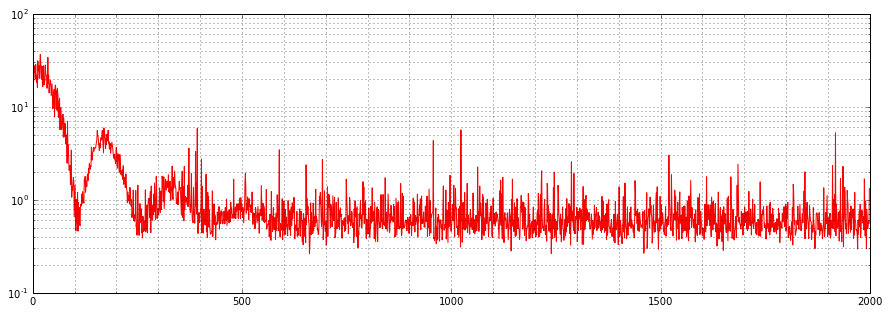

In [14]:
plt.figure(figsize=(15, 5))
plt.grid(which='both')
plt.minorticks_on()
plt.plot(Diamond.rnn.MSEs, color='red')
plt.yscale('log')
plt.show()

What causes the oscillation in the first 600 iterations? Does the momentum cause swings?

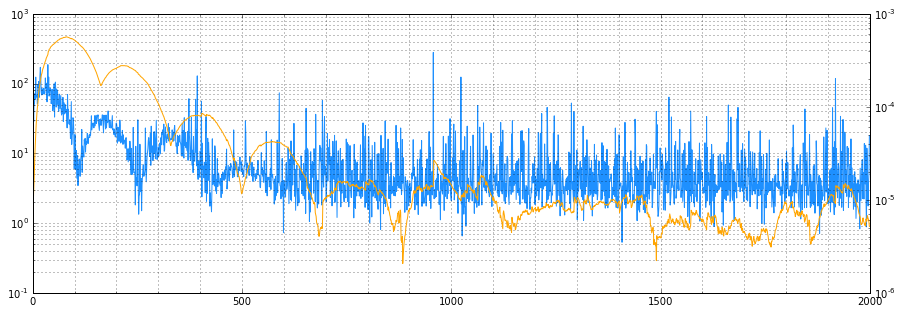

In [15]:
plt.figure(figsize=(15, 5))
plt.grid(which='both')
plt.minorticks_on()
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(Diamond.rnn.maxGrads, color='dodgerblue')
ax2.plot(Diamond.rnn.maxVelos, color='orange') # 
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.show()

The periods of cc. 100 iterations visible on this plit suggest that the momentum causes the parameter-vector to overshoot and pendle several times around its equilibrium before it settles down. This suggests that the momentum would need to be increased gradually during the training, starting small and reaching its full value after 300 to 500 iterations.
### The relationship between the maximum of the gradient and the MSE
In the scatter plot below the red series is the maximum of the gradient vs. the MSE in the same iteration. The blue series is the maximum of the gradient vs. the MSE in the next iteration.

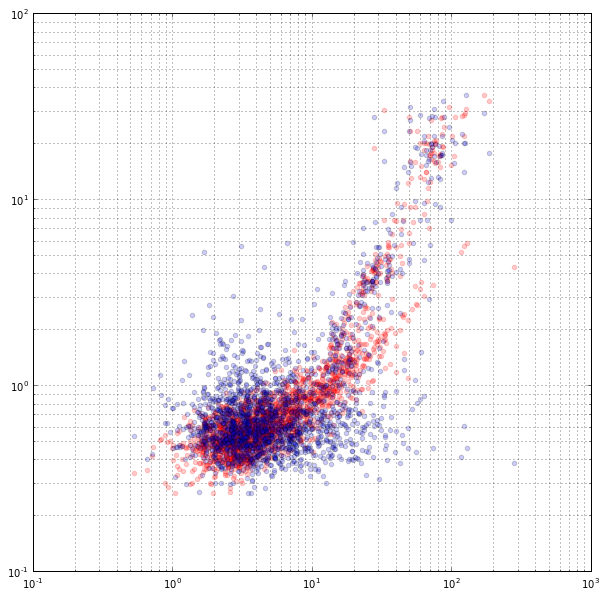

In [16]:
plt.figure(figsize=(10, 10))
plt.grid(which='both')
plt.minorticks_on()
plt.scatter(Diamond.rnn.maxGrads, Diamond.rnn.MSEs, color='red', alpha=0.2)
plt.scatter(Diamond.rnn.maxGrads[:-1], Diamond.rnn.MSEs[1:], alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.show()

The red series (maximum of the gradient vs. the MSE in the same iteration) shows higher correlation (more linear shape) than the blue series (maximum of the gradient vs. the MSE in the next iteration).

In these plots I do not see evidence of extreme gradient values diverting the parameter vector. I expected a high gradient is followed in the next iteration step by a high MSE value. The plots show that maxGrad is less correlated to the MSE in the next iteration than to the MSE in the current iteration. This suggests that the high MSE causes high gradients, not the other way around.

The high MSEs are likely to be caused by accidently sampling rare data points that the current parameter values do not explain. To validate this assumption I will plot 2000 minibatches without updating the gradient.

In [17]:
MSEs = list()
for i in range(2000):
    test_X_samples, test_RT_samples = Diamond.data.sample(128)
    results = Diamond.rnn.predict(test_X_samples, test_RT_samples)
    MSEs.append(results[2])
    

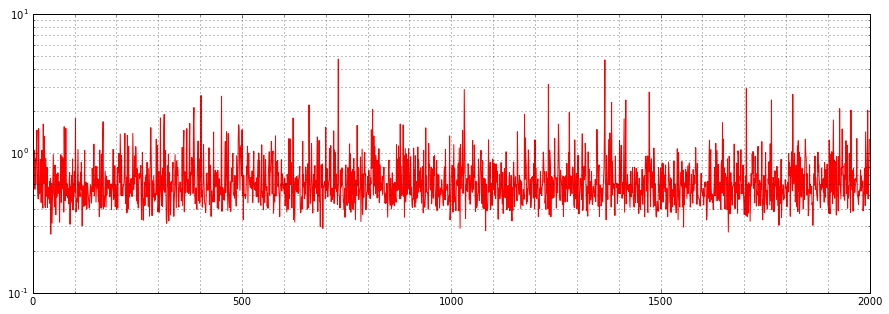

In [18]:
plt.figure(figsize=(15, 5))
plt.grid(which='both')
plt.minorticks_on()
plt.plot(MSEs, color='red')
plt.yscale('log')
plt.show()

The plot is very similar to that of Diamond.rnn.MSEs . Let's examine the distribution of the two data sets after excluding the first 600 data points (which were generated at the beginning of the training when the MSE was still high).

-0.4981111638 -0.492357710699
1.55516665437 1.73137770329


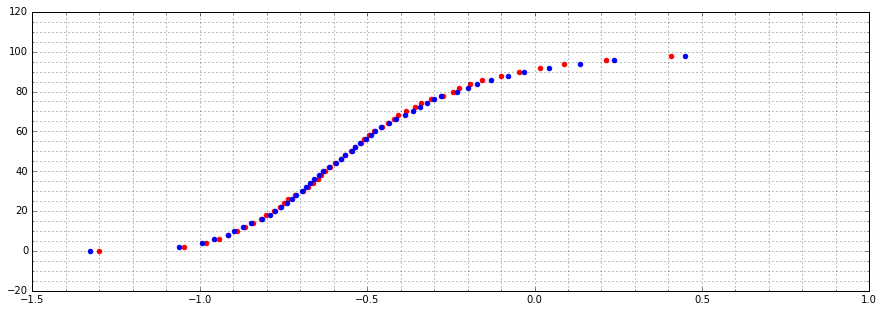

In [19]:
print np.log(MSEs[600:]).mean(), np.log(Diamond.rnn.MSEs[600:]).mean()
print np.log(MSEs[600:]).max(), np.log(Diamond.rnn.MSEs[600:]).max()
    
# for p in range(0, 100, 10):
#     print np.percentile(np.log(MSEs[600:]), p), np.percentile(np.log(Diamond.rnn.MSEs[600:]), p)

plt.figure(figsize=(15, 5))
plt.grid(which='both')
plt.minorticks_on()
for s, c in (MSEs[600:], 'red'), (Diamond.rnn.MSEs[600:], 'blue'):
    l = [(np.percentile(np.log(s), p), p) for p in range(0, 100, 2)]
    plt.scatter(*zip(*l), color=c )
# plt.yscale('log')
plt.show()    

These distributions are very simillar. My conclusion is that **the spikes in the training error are caused by the sampling and not because "cliffs" catapult the parameter vector!** We would need more of these spikes, so that we can learn from them!
## Greedy unit-wise supervised pre-training

In [20]:
def createStageWiseTrainedRNN(n, leak=0, oversizing=1):
    """ @param n: number of inputs to the RNN
        @param leak: slope of the ReLUs for the negative domain 
        @param oversizing: ratio of # of ReLUs to # of inputs
    """
    print "Creating NWayRNN"
    assert n > 0
    m = int(n * oversizing)
    
    class StageWiseTrainedRNN(object):
        
        # every row (selected by 0th coord) is an observation, 
        # fields in a row (1st coord) are child trx resp time in the observation
        X = T.dmatrix('X')  

        # input-to-ReLU connections
        # row i contains the weights through which input i feeds into the ReLUs
        # column j stores the weights through which the inputs feed into unit j
        U = theano.shared(np.zeros((n, m)), 'U')
        
        # inter-ReLU connections, 
        # row i contains the weights through which unit i feeds into higher order units
        # column j stores the weights through which lower order units feed into unit j
        W = theano.shared(np.zeros((m, m)), 'W')
        
        # all the params adjusted during optimisation
        params = [U, W]
        u_shape = (n, m)
        w_shape = (m, m)
        shapes = [u_shape, w_shape]
        
        # every row (selected by 0th coord) is an observation, 
        # fields in a row (1st coord) are input to the n ReLUs
        xU = T.dot(X, U)
        
        h = [T.nnet.relu( xU[:,0], alpha=leak )] #
        for t in range(1, m):
            input2relu = xU[:,t] + T.dot(T.stack(h[:t], axis=1), W[:t, t])
            h.append(T.nnet.relu(input2relu, alpha=leak)) 
        
        # The expected response time from the model:
        RT = h[-1]

        # Actual parent resp time, each observation on a separate row
        y = T.dvector('y')

        # residual:
        epsilon = y - RT.T
        
        # Mean squared error
        MSE = 0.5 * T.pow(epsilon, 2).mean() 

        ### REGULARIZATION ###
        
        # Most elements of W and U should be 0, so we apply LASSO on them:
        l1 = T.dscalar('lambda1')  # regularization parameter for Lasso
        L1 = T.sum(abs(U)) + T.sum(abs(W))
        
        # We train in m stages, quasi 'ReLU-wise', so we need 2 kinds of parameters:
        # - a prior estimate for the values of the sought variables, i.e. U and W 
        U0 = theano.shared(np.zeros((n, m)), 'U0')
        W0 = theano.shared(np.zeros((n, m)), 'W0')
        
        # - a regularization strength for the inputs feeding into the m ReLUs, i.e. for each column of U
        l_u = theano.shared(np.ones((m, )), 'l')    
        
        # - a regularization strength for the cross-feed of the m ReLUs, i.e. for each cell of W
        l_w = theano.shared(np.ones((m, )), 'l')    
        
        # overall regularization strength for ReLU-wise training
        l2u = T.dscalar('lambda2u')  
        l2w = T.dscalar('lambda2w')  

        dU = U - U0;   dU2 = dU * dU;   L2u = T.dot(  dU2           , l_u).sum() 
        dW = W - W0;   dW2 = dW * dW;   L2w = T.dot( T.dot(l_w, dW2), l_w).sum()
        
        # the cost function
        E = MSE + l1*L1 + L2u*l2u + L2w*l2w
        step_size = T.dscalar('step_size')
        momentum = T.dscalar('momentum')

        # the gradients:
        gradEs = [T.grad(E, param) for param in params]

        velocities = [theano.shared(np.zeros(shape)) 
                          for param, shape in zip(params, shapes)]

        #####################################
        ######## Training function ##########
        
        velocity_updates = [ (velocity, momentum * velocity - step_size * gradE )
                        for velocity, gradE in zip(velocities, gradEs)]
        
        updates = [ (param, param + velocity)
                        for param, velocity in zip(params, velocities)]
        

        training_result_variables = ('RT', 'epsilon', 'MSE', 'E',)
        train = staticmethod(theano.function(
                  inputs = [X, y, step_size, momentum, l1, l2u, l2w], #
                  outputs = [RT, epsilon, MSE, E, ] + velocities ,
                  updates = velocity_updates + updates
                    ))
        
        #####################################
        ####### Prediction function #########

        prediction_result_variables = 'RT', 'epsilon', 'MSE', 'xU'
        predict = staticmethod(theano.function(inputs=[X, y], 
                                               outputs=[RT, epsilon, MSE, xU] + h))

        #####################################
        ###### Stage update functions ########
        
        # the stage we start or finish (numbered starting -1 to -m)
        j = T.iscalar('j')  
        
        # The regularization weight for the ReLU being trained
        l_j = T.dscalar('l_j')
        
        # Increase the above weight by this factor in every subsequent stage
        gamma = T.dscalar('gamma')
        
        # the value to initialize the new column of U from
        U_init = T.dmatrix('U_init')
        
        # the value to initialize the new column of W from
        W_init = T.dmatrix('W_init')

        # run this function before every stage
        init_stage = staticmethod(theano.function(
                inputs = [j, U_init, W_init], 
                updates = [(U  , T.set_subtensor(U  [:, j ], U_init[:, j ]) ),  # init column j
                           (W  , T.set_subtensor(W  [j, j:], W_init[j, j:]) ),  # init row j above the diagonal
                           (l_u, T.set_subtensor(l_u[j    ], 1            ) ),
                           (l_w, T.set_subtensor(l_w[j    ], 1            ) ),
                          ]
            ))
        
        # run this function after every stage
        finish_stage = staticmethod(theano.function(
                inputs = [j, gamma], 
                updates = [(U0 , T.set_subtensor(U0 [ :, j:], U  [ :, j:]) ),  # copy last j columns
                           (W0 , T.set_subtensor(W0 [j:, j:], W  [j:, j:]) ),  # copy j x j sub-matrix
                           (l_u, T.set_subtensor(l_u[j:], l_u[j:] *        gamma ) ),
                           (l_w, T.set_subtensor(l_w[j:], l_w[j:] * T.sqrt(gamma)) ),
                          ]
            ))
        
        def stages(self, U_init, W_init, gamma):
            """ Iterate through the stages, setting the regularization parameters
            """
            n, m = self.u_shape
            bigNum = 1e8   # a very big value, for very strong regularization
            gamma = np.exp(min(np.log(gamma), np.log(bigNum)/m))
            self.l_u.set_value(np.ones((m,)) * bigNum)
            self.l_w.set_value(np.ones((m,)) * np.sqrt(bigNum))
            
            for j in range(-1, -m-1, -1):
                self.init_stage(j, U_init, W_init)
                yield j
                self.finish_stage(j, gamma)
        
        def __init__(self, step_size, momentum, l1, gamma, l2u, l2w, training_steps, data, 
                     batch_size, MSE_limit, rng, num_runs=1):
            assert 0.0 <= momentum < 1.0
            self.step_size, self.momentum, self.training_steps,  self.MSE_limit = \
                 step_size,      momentum,      training_steps,       MSE_limit
            self.l1, self.l2u, self.l2w, = l1, l2u, l2w, 

            if verbose:
                print ("Training the model using the following parameters:"
                       "\nstep_size = {},\tlambda1 = {},\tlambda2u = {},\tlambda2w = {},\ttraining_steps = {}" \
                        .format(step_size, l1, l2u, l2w, training_steps))

            bestMSE = 1e128
            self.training_results = []
            
            self.U .set_value(np.zeros(self.u_shape))
            self.W .set_value(np.zeros(self.w_shape))

            self.U0.set_value(np.zeros(self.u_shape))
            self.W0.set_value(np.zeros(self.w_shape))
            
            U_init = ( rng.uniform(low=-1, high=1, size=self.u_shape) * 1e-4)
            W_init = ( rng.uniform(low=-1, high=1, size=self.w_shape)
                                     * (np.ones(self.w_shape) - np.tri(*self.w_shape)) * 1e-1
                                     )
                            
            self.MSEs = list()
            for j in self.stages(U_init, W_init, gamma=gamma):
                print
                print '*'*10, 'Stage #{}'.format(-j), '*'*10
                print self.l_u.get_value() * l2u
                print self.l_w.get_value() * l2w
                print 'Before training:'
                for param in self.params:
                    print param.get_value()
                print 'Priors:'
                print self.U0.get_value()
                print self.W0.get_value()
                
                steps = count(0)
                grace_counter = reversed(xrange(self.training_steps))
                while next(grace_counter):
                    i = next(steps)
                    train_X_samples, train_RT_samples = data.sample(batch_size)
                    result = self.train(train_X_samples, train_RT_samples, self.step_size, 
                                        self.momentum, lambda1=l1, lambda2u=l2u, lambda2w=l2w) #
                    RT, epsilon, MSE, E, velocityU, velocityW, = result
                    self.MSEs.append(MSE)
                    if MSE < bestMSE:
                        print ("Batch #{}: Cost={:5.3f}, "
                               "MSE={:5.3f}"
                                .format(i, float(E), float(MSE), ))
                    else:
                        pass #print '{:5.3f}'.format(float(MSE)),
                    if MSE < bestMSE:
                        bestMSE = MSE
                        grace_counter = reversed(xrange(self.training_steps))
                    if MSE < MSE_limit:
                        break
                        
                print 'After training:'
                for param in self.params:
                    print param.get_value()

            self.training_results.append(
                dict(zip(self.training_result_variables, result))
                )
            self.training_results[-1]['training_steps'] = training_steps
            if verbose:
                print "MSE = {}".format(self.training_results[-1]['MSE'])

        def __call__(self, data):
            prediction_result = self.predict(data.test_X_samples, data.test_RT_samples)
            return dict(zip(self.prediction_result_variables, prediction_result))

        @classmethod
        def evaluate_real(cls, Sampler, num_children, step_size, l_min, l_max, 
                          training_steps, batch_size, N, MSE_limit, rng, parallelSequentialMix=-1, ):
            """ Determine how the real values of the model parameters impact the error.
            """
            results = list() 
            for i in range(N):
                if verbose:
                    print "i = {}".format(i)
                data = Sampler.random_data(num_children=num_children, parallelSequentialMix=parallelSequentialMix, 
                                           training_set_size=5000, validation_set_size=0, test_set_size=5000)
                model = cls(step_size, l_min, l_max, training_steps, data, batch_size, MSE_limit, rng)
                results.append( (data, model.training_results, model(data)))
            return results    ;

    print "Created NWayRNN"
    return StageWiseTrainedRNN

### GUST on the 2+1 concurrency structure
Let's start with a relatively easy one, and compare it to the N-way RNN!

In [21]:
%%time
class TwoConcurrentOneSerial(object):
    
    # alpha=-100, beta=0.0 ensure the child response times do not contain
    # additive noise
    structure = Trx('0', alpha=-100, beta=0.0)|Trx('1', alpha=-100, beta=0.0) \
                    - Trx('1', alpha=-100, beta=0.0)

    graph = FSBGraph()
    graph.start_node, graph.end_node = structure.generate_graph(graph)

    data = FSBSampler(graph, num_children=3)
    RNN = createStageWiseTrainedRNN(3, leak=-1.0, oversizing=1)
    rnn = RNN(step_size=2e-3, momentum=0.9, l1=1e-2, gamma=4.0, l2u=1e-5, l2w=1e-4, 
                training_steps=1000, data=data, 
                batch_size=128, MSE_limit=1e-8, rng=np.random.RandomState(1235))

Generating 0 training, 0 validation and 0 test samples using the following concurrency structure:
Creating NWayRNN
Created NWayRNN
Training the model using the following parameters:
step_size = 0.002,	lambda1 = 0.01,	lambda2u = 1e-05,	lambda2w = 0.0001,	training_steps = 1000

********** Stage #1 **********
[ 1000.  1000.     0.]
[ 1.  1.  0.]
Before training:
[[ 0.  0. -0.]
 [ 0.  0.  0.]
 [ 0.  0. -0.]]
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -0.]]
Priors:
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
Batch #0: Cost=12.321, MSE=12.321
Batch #2: Cost=11.978, MSE=11.978
Batch #3: Cost=8.006, MSE=8.006
Batch #7: Cost=7.177, MSE=7.173
Batch #8: Cost=5.634, MSE=5.629
Batch #10: Cost=5.425, MSE=5.416
Batch #12: Cost=3.232, MSE=3.219
Batch #13: Cost=2.196, MSE=2.180
Batch #14: Cost=1.226, MSE=1.207
Batch #15: Cost=0.868, MSE=0.847
Batch #16: Cost=0.519, MSE=0.495
Batch #34: Cost=0.334, MSE=0.308
Batch #36: Cost=0.202, MSE=0.178
Batch #80: Cost=0.

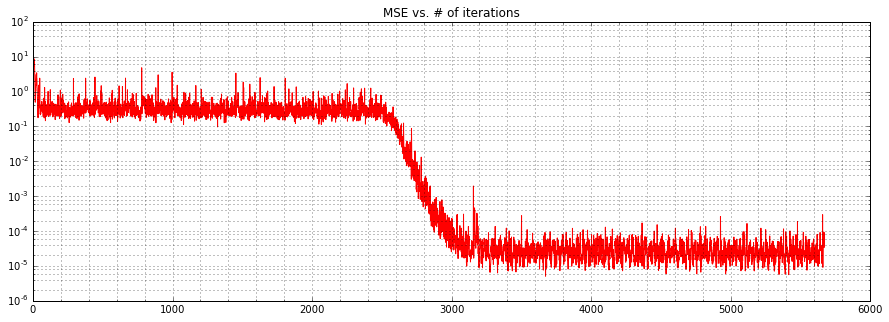

In [22]:
plt.figure(figsize=(15, 5))
plt.title('MSE vs. # of iterations')
plt.grid(which='both')
plt.minorticks_on()
plt.plot(TwoConcurrentOneSerial.rnn.MSEs, color='red')
plt.yscale('log')
plt.show()

**Clearly there is significant benefit in the pre-training!**
In the [previous notebook](ReLU 01 - Some trivial networks.ipynb) without pretraining we were not able to reach this level of improvement, although we oversized the network by a factor of 2 and allowed 20000 iterations!

Now let's go for the real thing!
### GUST on the diamond

In [23]:
%%time
class DiamondStageWise(object):
    
    # alpha=-100, beta=0.0 ensure the child response times do not contain
    # additive noise
    graph = FSBGraph()
    graph.add_edge('start', 'B1', alpha=-100, beta=0.0)
    graph.add_edge('start', 'B2', alpha=-100, beta=0.0)
    graph.add_edge('B1', 'end', alpha=-100, beta=0.0)
    graph.add_edge('B2', 'end', alpha=-100, beta=0.0)
    graph.add_edge('B1', 'B2', alpha=-100, beta=0.0)

    #graph.start_node, graph.end_node = graph.nodes['start'], graph.nodes['end']
    graph.start_node, graph.end_node = 'start', 'end'
    data = FSBSampler(graph, num_children=5)
    RNN = createStageWiseTrainedRNN(5, leak=-1.0, oversizing=1)
    rnn = RNN(step_size=2e-3, momentum=0.9, l1=1e-3, gamma=4.0, l2u=1e-6, l2w=1e-5, 
                training_steps=1000, data=data, 
                batch_size=128, MSE_limit=1e-8, rng=np.random.RandomState(1235))

Generating 0 training, 0 validation and 0 test samples using the following concurrency structure:
Creating NWayRNN
Created NWayRNN
Training the model using the following parameters:
step_size = 0.002,	lambda1 = 0.001,	lambda2u = 1e-06,	lambda2w = 1e-05,	training_steps = 1000

********** Stage #1 **********
[ 100.  100.  100.  100.    0.]
[ 0.1  0.1  0.1  0.1  0. ]
Before training:
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Priors:
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Batch #0: Cost=17.423, MSE=17.423
Batch #2: Cost=15.216, MSE=15.216
Batch #5: Cost=11.328, MSE=11.327
Batch #6: Cost=8.681, MSE=8.679
Batch #8: 

Note the round parameter values displayed at the end of stage 3! With only 3 ReLUs the diamond can be represented perfectly!

For sake of completeness, let's examine the evolution of the MSE. 

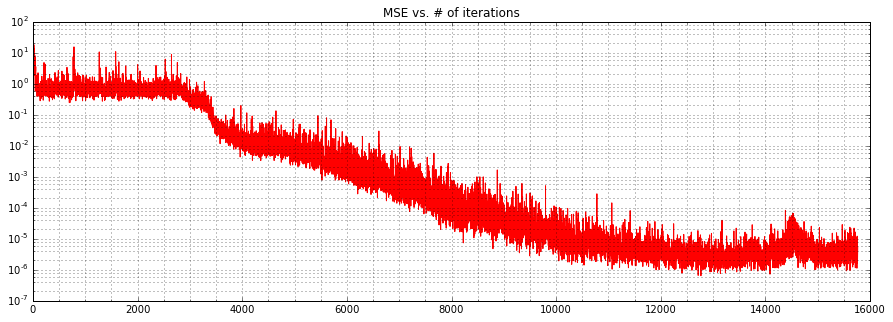

In [24]:
plt.figure(figsize=(15, 5))
plt.title('MSE vs. # of iterations')
plt.grid(which='both')
plt.minorticks_on()
plt.plot(DiamondStageWise.rnn.MSEs, color='red')
plt.yscale('log')
plt.show()

In the last 500 iterations the parameter-vector drifts away from the optimum. Ill-conditioning? Overfitting? Here the model has superfluous representational capacity.

My theory for explaining the success of GUST vs. the failure of simple optimisation is that the Hessian is ill-conditioned in the latter case, and thus no proper step size can be chosen. With GUST the representation capacity of the network is initially kept low, so the non-regularized ("free") parameters of the network are overdetermined instead of being undertedermined (ill-conditioned). By adding the units one-by-one, the parameter-vector follows a trajector that avoids the ill-conditioned regions (except perhaps after adding the last units, where the representational capacity is already beyond the necessary level).

This hypothesis suggests that by fighting ill-conditioning through varying the step size throughout the training, in accordance with the conditioning of the Hessian, we can achieve similar results. A simple way of aligning the step size with the conditioning is line search: let's try it!

## Line search
Below we implement a version of [golden ratio search](https://en.wikipedia.org/wiki/Golden-section_search) to optimize the step size. The searched for parameter is actually the logarithm of the step size. We assume that the optimal step size is within one order of magnitude of the optimal step size for the previous gradient descent iteration, and thus search in the $[0.1\cdot prevstepsize, 10\cdot prevstepsize]$ range. Originally I implemented this restriction to reduce the number of iterations in the golden ration search algorithm; by experimenting with different range sizes it turned out that the optimal step size can change from one iteration to the other by more than an order of magnitude, but following its sharp decreases exactly may lead a reduced optimization performance (presumably due to stucking in local minima).

In [54]:
def createNWayRNNLineSearch(n, leak=0, oversizing=1):
    """ @param n: number of inputs to the RNN
        @param leak: slope of the ReLUs for the negative domain 
        @param oversizing: ratio of # of ReLUs to # of inputs
    """
    print "Creating NWayRNNLineSearch"
    assert n > 0
    m = n * oversizing
    
    def compute_MSE(m, U, W, X, y):
        # every row (selected by 0th coord) is an observation, 
        # fields in a row (1st coord) are input to the n ReLUs
        xU = T.dot(X, U)
        h = [T.nnet.relu( xU[:,0], alpha=leak )] #
        for t in range(1, m):
            input2relu = xU[:,t] + T.dot(T.stack(h[:t], axis=1), W[:t, t])
            h.append(T.nnet.relu(input2relu, alpha=leak)) 

        # The expected response time from the model:
        RT = h[-1]

        # residual:
        epsilon = y - RT.T

        # Mean squared error
        MSE = 0.5 * T.pow(epsilon, 2).mean() 

        return RT, epsilon, MSE, xU
        
    class NWayRNNLineSearch(object):
        
        # every row (selected by 0th coord) is an observation, 
        # fields in a row (1st coord) are child trx resp time in the observation
        X = T.dmatrix('X')  

        # Actual parent resp time, each observation on a separate row
        y = T.dvector('y')

        # input-to-ReLU connections
        U = theano.shared(np.zeros((n, m)), 'U')
        
        # inter-ReLU connections
        W = theano.shared(np.zeros((m, m)), 'W')
        
        # all the params adjusted during optimisation
        params = [U, W]
        u_shape = (n, m)
        w_shape = (m, m)
        shapes = [u_shape, w_shape]
        
        RT, epsilon, MSE, xU = compute_MSE(m, U, W, X, y)
        
        l1 = T.dscalar('lambda1')  # regularization parameter for Lasso

        L1 = T.sum(abs(U)) + T.sum(abs(W))
        
        # the cost function
        E = MSE + l1*L1 #+ l2*L2

        # the gradients:
        gradient_E_U = T.grad(E, U)
        gradient_E_W = T.grad(E, W)

        direction_U, direction_W = [theano.shared(np.zeros(shape)) 
                                      for param, shape in zip(params, shapes)]
                
        momentum = T.dscalar('momentum')
        
        direction_U_update = (direction_U, momentum * direction_U - gradient_E_U )
        direction_W_update = (direction_W, momentum * direction_W - gradient_E_W )
        direction_updates = [ direction_U_update, direction_W_update]
        
        training_result_variables = ('RT', 'epsilon', 'MSE', 'E',)
        update_directions = staticmethod(theano.function(
                  inputs  = [X, y, momentum, l1, ], #l2
                  outputs = [RT, epsilon, MSE, E],
                  updates = direction_updates,
                  mode=NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True)
                    ))
        
        step_size = T.dscalar('step_size')
        new_U = U + step_size * direction_U
        new_W = W + step_size * direction_W
        new_params = new_U, new_W 
        
        try_step_size = staticmethod(theano.function(
                  inputs  = [step_size, X, y],
                  outputs = new_params + compute_MSE(m, new_U, new_W, X, y),  #  RT, epsilon, MSE, xU,
                  # mode=NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True)
                    ))
        
        selected_U = T.dmatrix('selected_U')  
        selected_W = T.dmatrix('selected_W')  

        update_params = staticmethod(theano.function(
                  inputs = [selected_U, selected_W],
                  outputs = [],
                  updates = [(U, selected_U), (W, selected_W)]
                    ))
        
        prediction_result_variables = 'RT', 'epsilon', 'MSE'
        predict = staticmethod(theano.function(inputs=[X, y], 
                                               outputs=[RT, epsilon, MSE, xU] ))


        # Code taken from https://en.wikipedia.org/wiki/Golden-section_search
        golden_ratio = (np.sqrt(5) + 1) / 2
        
        def find_step_size(self, a, b, X, y, orig_MSE, tolerance=1e-2):            
            c = b - (b - a) / self.golden_ratio
            d = a + (b - a) / self.golden_ratio
            limit = tolerance  # (b - a) * tolerance

            while abs(c - d) > limit:
#                 print a, c, d, b, np.exp(a), np.exp(b)
                # new_U, new_W, RT, epsilon, MSE, xU 
                c_MSE = self.try_step_size(np.exp(c), X, y)[4]
                d_MSE = self.try_step_size(np.exp(d), X, y)[4]
                
                if c_MSE < d_MSE or np.isnan(c_MSE) or np.isnan(d_MSE) or max(c_MSE, d_MSE) > orig_MSE:
                    b = d
                else:
                    a = c

                c = b - (b - a) / self.golden_ratio
                d = a + (b - a) / self.golden_ratio

            step_size = np.exp((b + a) / 2 )
            # new_U, new_W, RT, epsilon, MSE, xU                
            return self.try_step_size(step_size, X, y), step_size
            
        def __init__(self, step_size_limits, momentum, l_min, l_max, training_steps, data, 
                     batch_size, MSE_limit, rng, num_runs=1):
            assert 0.0 <= momentum < 1.0
            self.step_size_limits, self.momentum, self.training_steps,  self.MSE_limit = \
                 step_size_limits,      momentum,      training_steps,       MSE_limit
            self.l_max, self.l_min, = l_max, l_min, 

            if verbose:
                print ("Training the model using the following parameters:"
                       "\nlambda_min = {},\tlambda_max = {},\ttraining_steps = {}" \
                        .format(l_min, l_max, training_steps))

            lambdas = sorted(np.logspace(l_min, l_max, self.training_steps), 
                             reverse=True)
            
            bestMSE = 1e128
            self.training_results = []
            
            self.MSEs = list()
            self.step_sizes = list()
            for run in range(num_runs):
                if True:
                    self.U.set_value(rng.uniform(low=-1, high=1, size=self.u_shape) * 1e-4)
                    self.W.set_value(rng.uniform(low=-1, high=1, size=self.w_shape)
                                     * (np.ones(self.w_shape) - np.tri(*self.w_shape))
                                    )
                else:
                    self.U.set_value(np.ones(self.u_shape) * 1e-4 )
                    self.W.set_value( (np.ones(self.w_shape) - np.tri(*self.w_shape)) * 1e-0 )

                a, b = self.step_size_limits
                a = np.log(a)
                b = np.log(b)
                for i, l_ in zip(range(self.training_steps), lambdas):
                    train_X_samples, train_RT_samples = data.sample(batch_size)
                    
                    result = self.update_directions(
                                        train_X_samples, train_RT_samples, 
                                        self.momentum, lambda1=l_, ) #lambda2=l_*100
                    RT, epsilon, MSE, E = result
                    
                    (new_U, new_W, _RT, _epsilon, _MSE, xU), step_size = \
                                self.find_step_size(a, b, train_X_samples, train_RT_samples, MSE)
                        
                    a = np.log( step_size /10) 
                    b = np.log( step_size *10) 
                    
                    self.update_params(new_U, new_W)
                    
                    self.MSEs.append(MSE)
                    self.step_sizes.append(step_size)
                    if MSE < bestMSE :
                        print ("Batch #{}: lambda={:7.5f}, Cost={:7.5f}, "
                               "MSE={:f}, step_size={:f}"
                                .format(i, float(l_), float(E), float(MSE), step_size))
                        print 
                    else:
                        pass #print '{:7.5f}'.format(float(MSE)),
                    if MSE < bestMSE:
                        bestMSE = MSE
                    if MSE < MSE_limit:
                        break
                print "Batch #{}: lambda={:7.5f}, Cost={:7.5f}, MSE={:7.5f}\nWeights:"\
                        .format(i, float(l_), float(E), float(MSE))
                for param in self.params:
                    print param.get_value()

                self.training_results.append(
                    dict(zip(self.training_result_variables, result))
                    )
                self.training_results[-1]['training_steps'] = training_steps
                if verbose:
                    print "MSE = {}".format(self.training_results[-1]['MSE'])

        def __call__(self, data):
            prediction_result = self.predict(data.test_X_samples, data.test_RT_samples)
            return dict(zip(self.prediction_result_variables, prediction_result))

        @classmethod
        def evaluate_real(cls, Sampler, num_children, step_size, l_min, l_max, 
                          training_steps, batch_size, N, MSE_limit, rng, parallelSequentialMix=-1, ):
            """ Determine how the real values of the model parameters impact the error.
            """
            results = list() 
            for i in range(N):
                if verbose:
                    print "i = {}".format(i)
                data = Sampler.random_data(num_children=num_children, parallelSequentialMix=parallelSequentialMix, 
                                           training_set_size=5000, validation_set_size=0, test_set_size=5000)
                model = cls(step_size, l_min, l_max, training_steps, data, batch_size, MSE_limit, rng)
                results.append( (data, model.training_results, model(data)))
            return results    ;

    print "Created NWayRNNLineSearch"
    return NWayRNNLineSearch

In [59]:
%%time
class DiamondLineSearch(object):
    
    # alpha=-100, beta=0.0 ensure the child response times do not contain
    # additive noise
    graph = FSBGraph()
    graph.add_edge('start', 'B1', alpha=-100, beta=0.0)
    graph.add_edge('start', 'B2', alpha=-100, beta=0.0)
    graph.add_edge('B1', 'end', alpha=-100, beta=0.0)
    graph.add_edge('B2', 'end', alpha=-100, beta=0.0)
    graph.add_edge('B1', 'B2', alpha=-100, beta=0.0)

    #graph.start_node, graph.end_node = graph.nodes['start'], graph.nodes['end']
    graph.start_node, graph.end_node = 'start', 'end'
    data = FSBSampler(graph, num_children=5)
    RNN = createNWayRNNLineSearch(5, leak=-1.0, oversizing=1)
    rnn = RNN(step_size_limits=(1e-6, 1.0), momentum=0.9, l_min=-4, l_max=-2, 
                training_steps=8000, data=data, 
                batch_size=128, MSE_limit=1e-8, rng=np.random.RandomState(1236), num_runs=1)

Generating 0 training, 0 validation and 0 test samples using the following concurrency structure:
Creating NWayRNNLineSearch
Created NWayRNNLineSearch
Training the model using the following parameters:
lambda_min = -4,	lambda_max = -2,	training_steps = 8000
Batch #0: lambda=0.01000, Cost=29.52726, MSE=29.48994, step_size=0.051280

Batch #1: lambda=0.00999, Cost=3.48930, MSE=3.36631, step_size=0.008100

Batch #2: lambda=0.00999, Cost=2.33279, MSE=2.19809, step_size=0.002700

Batch #5: lambda=0.00997, Cost=1.30485, MSE=1.13943, step_size=0.002512

Batch #6: lambda=0.00997, Cost=0.95097, MSE=0.78270, step_size=0.000574

Batch #12: lambda=0.00993, Cost=0.87609, MSE=0.70552, step_size=0.007364

Batch #14: lambda=0.00992, Cost=0.74567, MSE=0.57264, step_size=0.006523

Batch #16: lambda=0.00991, Cost=0.74446, MSE=0.56995, step_size=0.003332

Batch #19: lambda=0.00989, Cost=0.63856, MSE=0.46241, step_size=0.000339

Batch #26: lambda=0.00985, Cost=0.62003, MSE=0.44378, step_size=0.000152

Batch

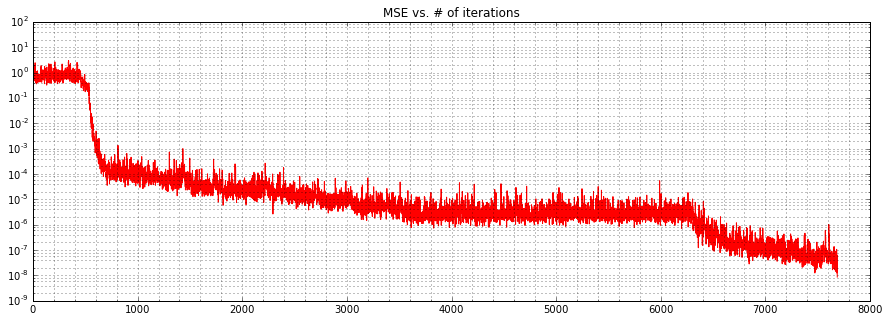

In [60]:
plt.figure(figsize=(15, 5))
plt.title('MSE vs. # of iterations')
plt.grid(which='both')
plt.minorticks_on()
plt.plot(DiamondLineSearch.rnn.MSEs, color='red')
plt.yscale('log')
plt.show()

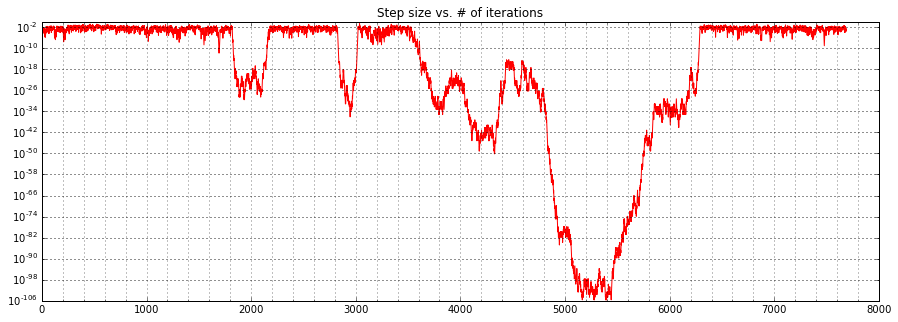

In [61]:
plt.figure(figsize=(15, 5))
plt.title('Step size vs. # of iterations')
plt.grid(which='both')
plt.minorticks_on()
plt.plot(DiamondLineSearch.rnn.step_sizes, color='red')
plt.yscale('log')
plt.show()

Wow, what a wild trajectory this optimization must have had!

Unfortunately the optimization runs do not seem to be exactly reproducable - each run follows a different trajectory, even of the same seed is used for the random initialization of the parameters. The only place where the non-determinism could be introduced is the training data, so that is the likely cause of the differring trajectories.

Lesson: use the same training & validation sets when comparing multiple parameter settings.